In [10]:
import sys
import os
import cv2
sys.path.append("..")

In [11]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")

x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

#Preprocess

x_train = [cv2.resize(image, (30, 30)) for image in x_train]
x_train = np.array(x_train)

y_train = np.reshape(y_train,[y_train.shape[0],1])

('X_train shape:', (4575, 30, 30, 3))


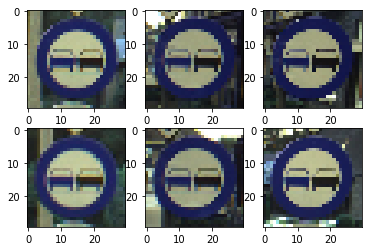

In [24]:
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_train[i])

print("X_train shape:",x_train.shape)
img_shape = x_train[1].shape


In [17]:
import tensorflow as tf
import keras, keras.layers as L
#s = keras.backend.get_session()

Using TensorFlow backend.


In [25]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    NFILTERS=16
    N1=256

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.normalization.BatchNormalization(axis=1))
    
    #Convolutions
    encoder.add(L.Conv2D(filters=NFILTERS*2,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.MaxPooling2D())

    
    encoder.add(L.Flatten()) 
    
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())    
    
    encoder.add(L.Dense(code_size))
   
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.normalization.BatchNormalization())
    
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())   
    
    
    decoder.add(L.Dense(np.prod(img_shape)//4))
    decoder.add(L.advanced_activations.LeakyReLU()) 
    decoder.add(L.normalization.BatchNormalization()) 
    decoder.add(L.Reshape((H//2,W//2,C)))   
    decoder.add(L.UpSampling2D())

    decoder.add(L.Deconv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=NFILTERS*2,kernel_size=3,padding="same")) 
    
    encoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=3,kernel_size=3,padding="same"))

    
    return encoder,decoder

In [26]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [27]:
autoencoder.fit(x=x_train,y=x_train,epochs=32,
                validation_data=[x_train,x_train])

Train on 4575 samples, validate on 4575 samples
Epoch 1/32
4575/4575 [==============================] - 51s 11ms/step - loss: 5461.7528 - val_loss: 2646.6449
Epoch 2/32
4575/4575 [==============================] - 46s 10ms/step - loss: 2492.3273 - val_loss: 2361.8670
Epoch 3/32
4575/4575 [==============================] - 44s 10ms/step - loss: 2324.6814 - val_loss: 2127.1607
Epoch 4/32
4575/4575 [==============================] - 41s 9ms/step - loss: 2232.2719 - val_loss: 2077.9003
Epoch 5/32
4575/4575 [==============================] - 50s 11ms/step - loss: 2159.4942 - val_loss: 1994.7928
Epoch 6/32
4544/4575 [============================>.] - ETA: 0s - loss: 2120.2630

KeyboardInterrupt: 

In [30]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()

('Final MSE:', 0.0049)


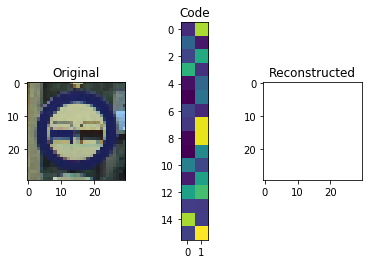

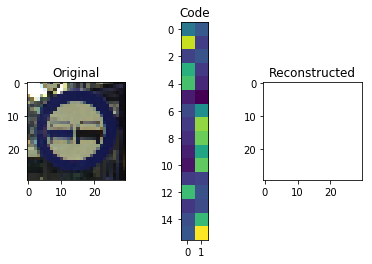

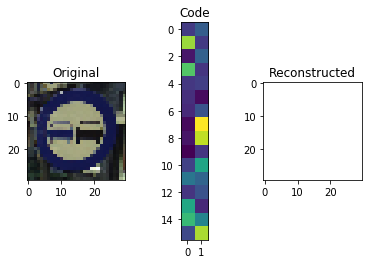

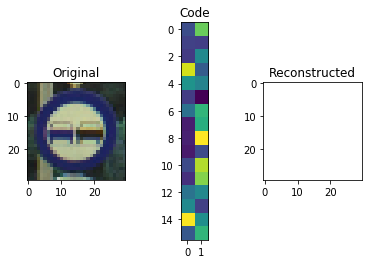

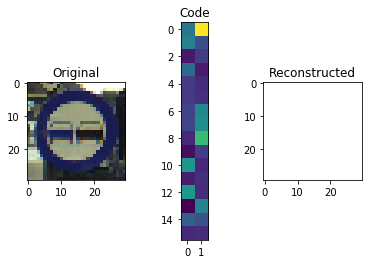

In [31]:
reconstruction_mse = autoencoder.evaluate(x_train,x_train,verbose=0)
reconstruction_mse = 0.0049
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = x_train[i]
    visualize(img,encoder,decoder)

In [41]:
images = x_train
codes = encoder.predict(images)
assert len(codes) == len(images)
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/Users/bedabratachoudhury/miniconda2/lib/python2.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [42]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [43]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

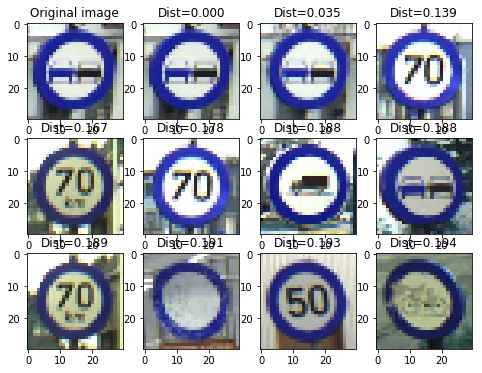

In [45]:
#smiles
show_similar(x_train[10])